In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'DLforCV_assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/DLforCV/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/DLforCV_assignment2/DLforCV/datasets
/content/drive/My Drive/DLforCV_assignment2


# Assignment2 : Enhancing Model Performance Using CNN and ViT

In this assignment, you will explore the implementation of two powerful neural network architectures: Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs).

Your objective in this task is not only to implement these models but also to improve their performance through the optimization of training techniques. You will be required to experiment with various strategies such as learning rate schedules, data augmentation, batch normalization, and other training methods to achieve the best results.

# Table of Contents

This assignment has 5 parts.

1. Part I, Preparation: we will use CIFAR-10 dataset.

2. Part II, CNN Implementation : we will implement and train a Convolutional Neural Network (CNN) on the CIFAR-10 dataset.

3. Part III, ViT : we will implement and train a Vision Transformer (ViT) on the CIFAR-10 dataset.

4. Part IV, CIFAR-10 open-ended challenge using CNN : please implement your own CNN based model to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features.

5. Part IV, CIFAR-10 open-ended challenge using ViT : please implement your own ViT based model to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features.


# Part I. Preparation

### GPU


You can manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. You should do this before running the following cells to import packages, since the kernel gets restarted upon switching runtimes.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


### Download dataset

Now, let's load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./DLforCV/datasets', train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./DLforCV/datasets', train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./DLforCV/datasets', train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Module API: Check Accuracy

Given the validation or test set, we can check the classification accuracy of a neural network.

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [4]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Basic Training Loop


We can now set up a basic training loop to train our network. We will train the model using Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks. We will use torch.functional.cross_entropy to compute the loss.

In [5]:
import torch.nn.functional as F  # useful stateless functions

def train(loader_train, model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

# Part II. CNN Implementation

 We will implement and train a Convolutional Neural Network (CNN) on the CIFAR-10 dataset.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `ThreeLayerConvNet`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

### Three-Layer CNN


It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Flatten the output feature (Hint : `torch.flatten`)
6. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: https://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [6]:

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # First convolutional layer: 5x5 filters with zero-padding of 2
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)

        # Second convolutional layer: 3x3 filters with zero-padding of 1
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)

        # Fully connected layer to num_classes classes
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)

        # Kaiming normal initialization for conv and fully connected layers
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity='relu')

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # First conv layer + ReLU
        x = F.relu(self.conv1(x))

        # Second conv layer + ReLU
        x = F.relu(self.conv2(x))

        # Flatten the output
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch

        # Fully connected layer to output scores
        scores = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Train a Three-Layer CNN

You should now use `ThreeLayerConvNet` class to train a three-layer ConvNet on CIFAR.

You don't need to tune any hyperparameters.

And you should train the model using SGD optimizer.

In [7]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Instantiate the model with the given parameters
model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=16, num_classes=10)

# Use Adam optimizer with the specified learning rate
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

train(loader_train, model, optimizer, epochs=1)

Iteration 0, loss = 3.3693
Checking accuracy on validation set
Got 147 / 1000 correct (14.70)

Iteration 100, loss = 1.8856
Checking accuracy on validation set
Got 270 / 1000 correct (27.00)

Iteration 200, loss = 1.8117
Checking accuracy on validation set
Got 348 / 1000 correct (34.80)

Iteration 300, loss = 1.7039
Checking accuracy on validation set
Got 417 / 1000 correct (41.70)

Iteration 400, loss = 1.6962
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Iteration 500, loss = 1.5627
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)

Iteration 600, loss = 1.2786
Checking accuracy on validation set
Got 479 / 1000 correct (47.90)

Iteration 700, loss = 1.5106
Checking accuracy on validation set
Got 481 / 1000 correct (48.10)



### Test set -- run this only once

In [8]:
best_model = model
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got 4890 / 10000 correct (48.90)


# Part III. ViT Implementation

Transformers (Vaswani et al., 2017) were originally designed for Natural language processing (NLP) tasks and were not inherently suited for images.However, Dosovitskiy et al. (2021) adapted the Transformer architecture for image classification by treating images as sequences of patches, akin to sequences of words in text processing. ViT demonstrated that with sufficient data and computational resources, Transformers could match or even surpass the performance of state-of-the-art CNNs on image classification tasks, especially when pretrained on large datasets.

In this assignment, you will implement a Vision Transformer (ViT) from scratch and apply it to the CIFAR-10 dataset.

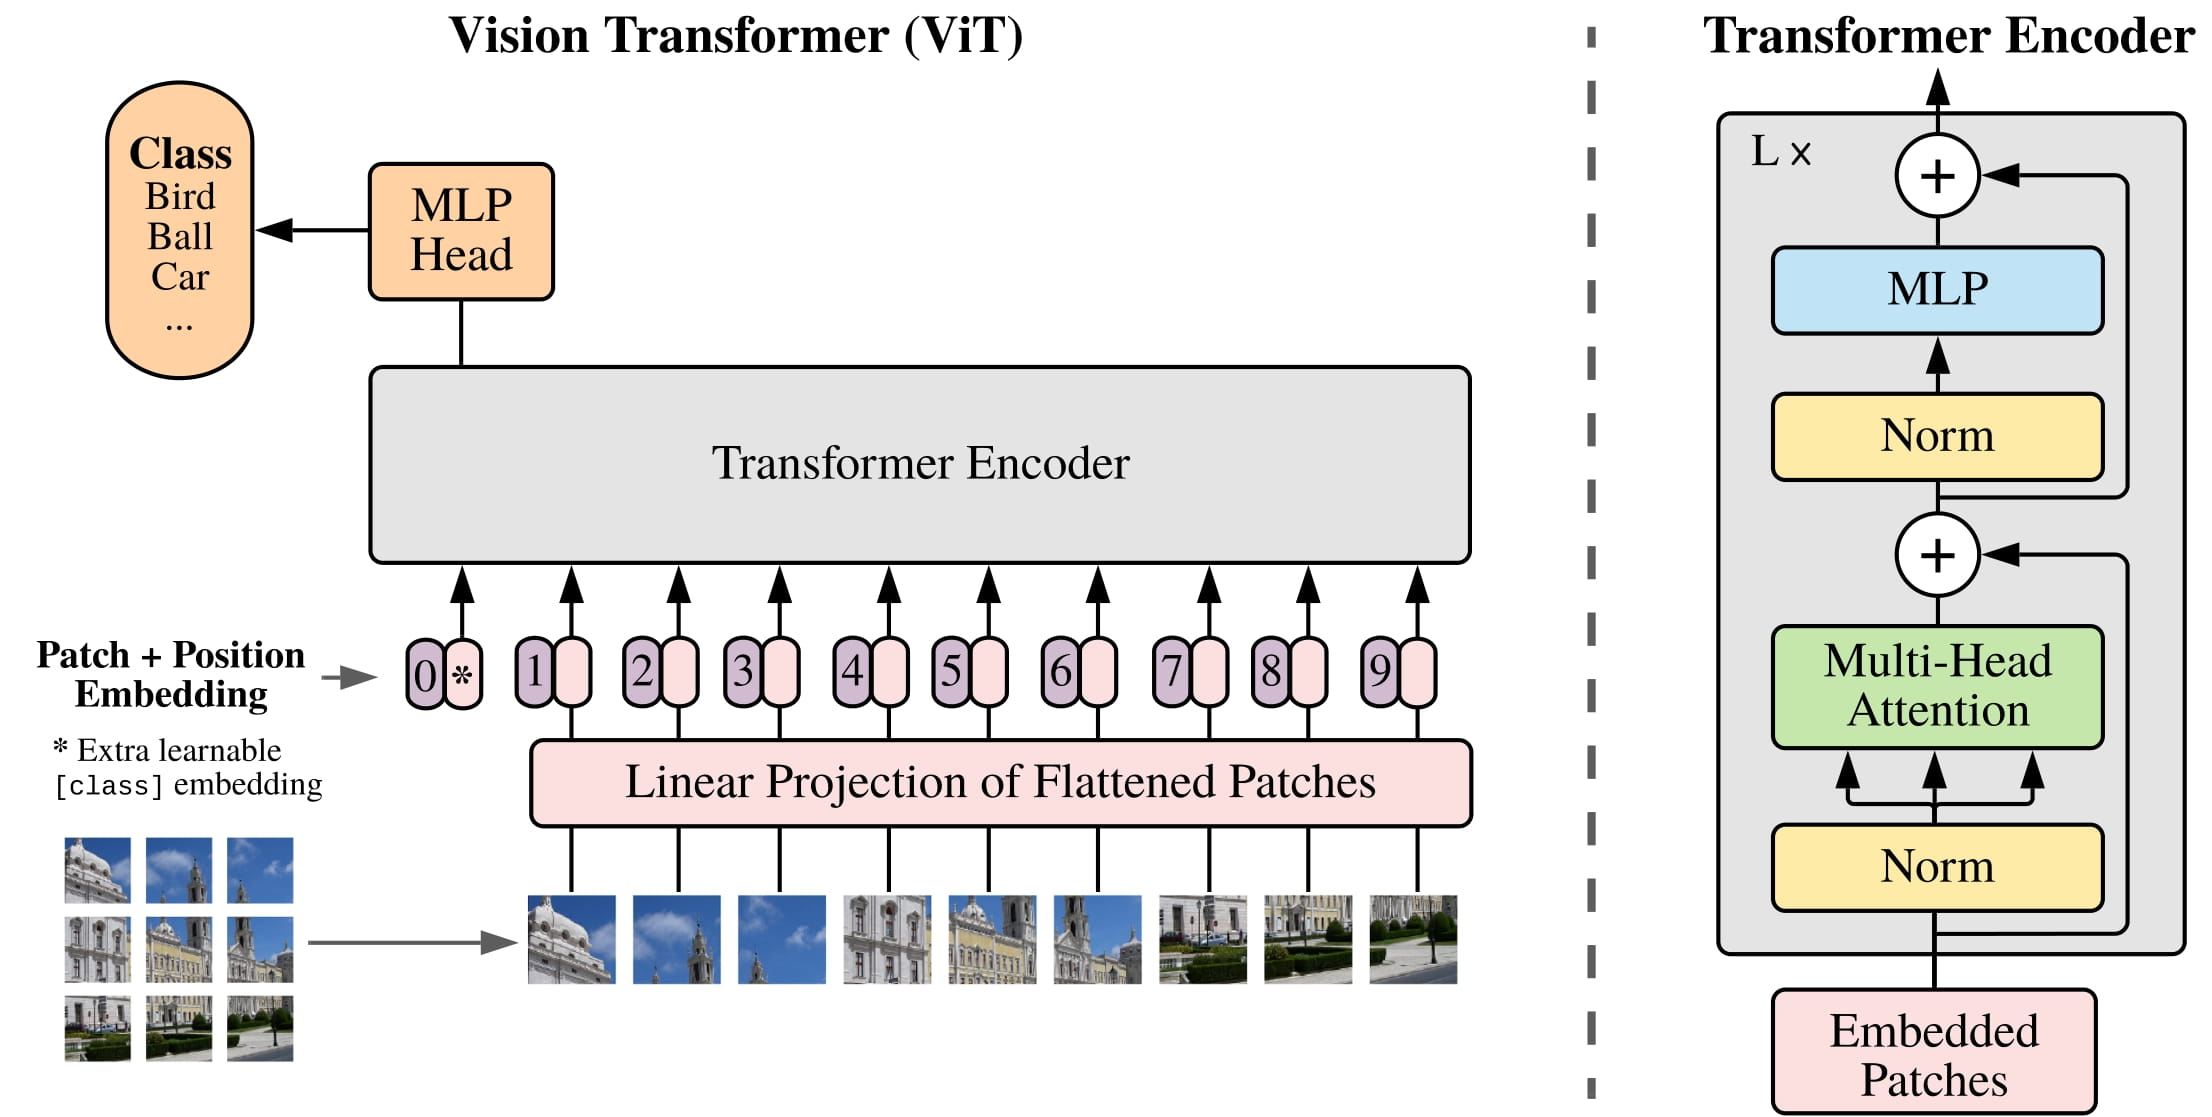

### Overall Architecture


The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention and MLP blocks (Eq. 2, 3), preceded by the patch embedding layer (Eq. 1). LayerNorm (Eq. 4) is then applied before every block, and residual connections after every block.

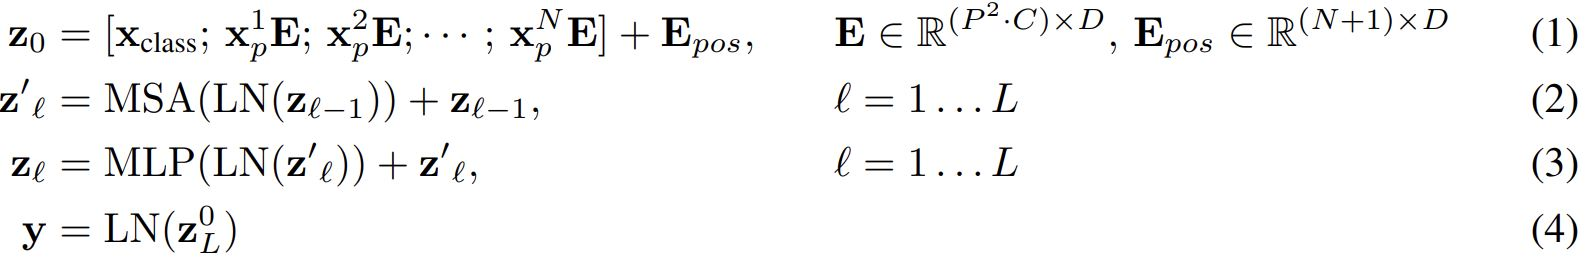

### Patch Embedding Layer

In the patch embedding layer, the image is reshaped into a sequence of flattened 2D patches $x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^2$
is the resulting number of patches. The Transformer uses constant embedding dimension $D$ through all of its layers, so we have to flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1).

As Transformer architecture is permutation invariant itself, we add position embeddings $\mathbf{E}_{pos}$ to the patch embeddings to retain positional information. In this assignment, we use learnable position embeddings (*i.e.* as parameters).

In addition to patch embeddings, ViT prepends a learnable embedding $z^0_0 = \mathbf{x}_{class}$ (the CLS token) to the sequence of embedded patches, whose state at the output of the Transformer encoder $z^0_L$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $z^0_L$.

In contrast, we can use average pooled token for the final image representation as CNNs. You will implement the both version of ViTs.

In [9]:
import torch
import torch.nn as nn

class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_c, embed_dim, img_size, patch_size, is_cls_token=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.is_cls_token = is_cls_token

        # Calculate number of patches
        self.num_patches = (img_size // patch_size) ** 2

        ################################################################################
        # TODO: Instantiate your patch embedding layer, the CLS token,                 #
        # and the positional embedding.                                                #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Patch embedding layer: project patches to the embedding dimension
        self.patch_embed = nn.Conv2d(
            in_channels=in_c,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # CLS token: a learnable parameter for the [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if is_cls_token else None

        # Positional embeddings: learnable position embeddings for all patches + CLS token (if used)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + (1 if is_cls_token else 0), embed_dim))

        # Initialize parameters
        nn.init.trunc_normal_(self.pos_embed, std=0.02)  # Truncated normal initialization for pos embedding
        if is_cls_token:
            nn.init.trunc_normal_(self.cls_token, std=0.02)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        B, C, H, W = x.shape

        ################################################################################
        # TODO: Implement the forward function for a patch embedding layer.            #
        # HINT: You can use torch.expand and torch.cat functions to prepend the CLS    #
        # token.                                                                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Apply the patch embedding layer (B, C, H, W) -> (B, embed_dim, H/patch_size, W/patch_size)
        x = self.patch_embed(x)  # Shape: (B, embed_dim, H/patch_size, W/patch_size)

        # Flatten the patches into a sequence (B, embed_dim, N)
        x = x.flatten(2).transpose(1, 2)  # Shape: (B, N, embed_dim), where N = num_patches

        # Prepend the CLS token to the sequence (if used)
        if self.is_cls_token:
            cls_tokens = self.cls_token.expand(B, -1, -1)  # Shape: (B, 1, embed_dim)
            x = torch.cat((cls_tokens, x), dim=1)  # Shape: (B, N + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed  # Shape: (B, N + 1, embed_dim) or (B, N, embed_dim) without CLS token

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return x

if __name__ == '__main__':
    img = torch.randn([2, 3, 32, 32])
    embedding = PatchEmbeddingLayer(in_c=3, embed_dim=192, img_size=32, patch_size=4)
    z = embedding(img)
    print(z.size())

torch.Size([2, 65, 192])


### Multihead self-attention

Self-attention (SA) allows ViT to integrate information across the entire
image even in the lowest layers. We first map the input sequence $z \in \mathbb{R}^{N \times D}$ into three separate embeddings $q,k$ and $v$ (Eq. 5). Then we compute a weighted sum over all values $v$ in the sequence (Eq. 7). The attention weights $A_{ij}$ are based on the pairwise similarity between two elements of the sequence and their respective query $q_i$ and key $k_j$ representations (Eq. 6).

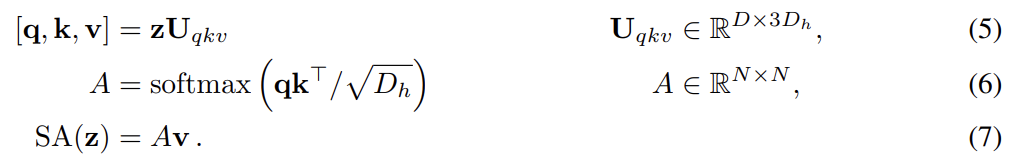

Multihead self-attention (MSA) is an extension of SA in which we run $k$ self-attention operations, called “heads, in parallel, and project their concatenated outputs. To keep compute and number of parameters constant when changing $k, Dh$ (Eq. 5) is typically set to $D/k$.

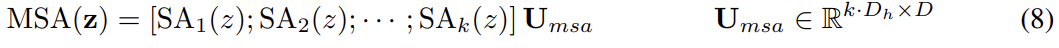

In [10]:
import torch.nn.functional as F
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=12, drop=0.):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.o = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        B, N, D = x.shape
        ################################################################################
        # TODO: Implement the MSA layer. You can add dropout after the MSA operation.
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Linear projections to get query, key, value
        q = self.q(x)  # Shape: (B, N, D)
        k = self.k(x)  # Shape: (B, N, D)
        v = self.v(x)  # Shape: (B, N, D)

        # Reshape for multi-head: (B, N, num_heads, head_dim) -> (B, num_heads, N, head_dim)
        q = q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)

        # Compute scaled dot-product attention
        attn_weights = (q @ k.transpose(-2, -1)) * self.scale  # (B, num_heads, N, N)
        attn_weights = F.softmax(attn_weights, dim=-1)  # Normalize along the sequence length dimension
        attn_weights = self.dropout(attn_weights)  # Optional dropout for regularization

        # Compute attention output
        attn_output = attn_weights @ v  # (B, num_heads, N, head_dim)

        # Concatenate heads: (B, num_heads, N, head_dim) -> (B, N, embed_dim)
        attn_output = attn_output.transpose(1, 2).reshape(B, N, D)

        # Apply the output projection
        output = self.o(attn_output)  # (B, N, D)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return output

if __name__ == '__main__':
    img = torch.randn([2, 3, 32, 32])
    embedding = PatchEmbeddingLayer(in_c=3, embed_dim=192, img_size=32, patch_size=4)
    z = embedding(img)
    msa = MultiHeadSelfAttention()
    print(msa(z).size())

torch.Size([2, 65, 192])


### MLP layer

The MLP contains two layers with a GELU non-linearity (Eq. 3).
A common choice for the hidden dimension is x4 the input dimension.

In [11]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or 4 * in_features  # Hidden dimension is 4x the input dimension
        out_features = in_features  # Output size matches the input size

        ################################################################################
        # TODO: Implement the MLP layer. You can add dropout after each fc layer.      #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # First fully connected layer
        self.fc1 = nn.Linear(in_features, hidden_features)

        # GELU non-linearity
        self.gelu = nn.GELU()

        # Dropout after the first layer
        self.dropout1 = nn.Dropout(drop)

        # Second fully connected layer (output layer)
        self.fc2 = nn.Linear(hidden_features, out_features)

        # Dropout after the second layer
        self.dropout2 = nn.Dropout(drop)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward function of the MLP layer.                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # First layer + GELU activation + Dropout
        x = self.dropout1(self.gelu(self.fc1(x)))

        # Second layer + Dropout
        x = self.dropout2(self.fc2(x))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return x

### Define Transformer Block and ViT

We now define a transformer block by combining the MSA layer and the MLP layer defined above with LayerNorm.

In [12]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=2.,drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads=num_heads,drop=attn_drop)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio),drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

We finally define the entire ViT, stacking the patch embedding layer, Transformer blocks and the final classification head (final fc layer).

In [15]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_c=3, num_classes=10, embed_dim=192,
                 num_heads=12, mlp_ratio=2., drop=0., attn_drop=0.,is_cls_token=True):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.is_cls_token = is_cls_token
        norm_layer = nn.LayerNorm
        self.depth=12
        self.patch_embed = PatchEmbeddingLayer(in_c, embed_dim, img_size, patch_size,self.is_cls_token)
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, drop=drop, attn_drop=attn_drop)
            for i in range(self.depth)])

        # final norm
        self.norm = norm_layer(embed_dim)

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward function of ViT.
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Pass input through the patch embedding layer
        x = self.patch_embed(x)  # Shape: (B, N+1, D) or (B, N, D) without CLS token

        # Pass through the Transformer blocks
        x = self.blocks(x)  # Shape: (B, N+1, D) or (B, N, D)

        # Apply final normalization
        x = self.norm(x)  # Shape: (B, N+1, D) or (B, N, D)

        # If CLS token is used, take the CLS token output
        if self.is_cls_token:
            x = x[:, 0]  # Shape: (B, D)
        else:
            # If no CLS token, use average pooling over all tokens
            x = x.mean(dim=1)  # Shape: (B, D)

        # Apply the classification head to get the final scores
        scores = self.head(x)  # Shape: (B, num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return scores


def test_ViT():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ViT(is_cls_token=True)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ViT()


torch.Size([64, 10])


# Part IV. CIFAR-10 open-ended challenge using CNN

In this section, you can experiment with ***whatever hyperparameters you'd like while maintaining the three-layer CNN architecture in Part2. You can modify hyperparameters and codes for data preparation and training, but do not modify the code for the model class.***

 ***Achieve a higher accuracy on the CIFAR-10 test set than what was obtained in Part2 within 10 epochs***. You should use the check_accuracy from above.

Describe what you did at the end of this notebook.

Here are the official API documentation for each component.
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html



### Things you might try:
- **Number of channels**
- **Regularization**: l1, l2 weight regularization.
- ***Alternative optimizers***: Adam, Adagrad, RMSprop, etc.
- ***Data augmentation***: Horizontal flip, Crop, Color jittering, etc.
- ***Learning rate scheduler***: LambdaLR, StepLR, ExponentialLR, etc.
- ***Alternative loss for classification***

In [16]:
############################################################################
# You can modify below code if you want                                    #
############################################################################

NUM_TRAIN = 49000

your_transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

your_cifar10_train = dset.CIFAR10('./DLforCV/datasets', train=True, download=True,
                             transform=your_transform)
your_loader_train = DataLoader(your_cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

your_cifar10_val = dset.CIFAR10('./DLforCV/datasets', train=True, download=True,
                           transform=your_transform)
your_loader_val = DataLoader(your_cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

your_cifar10_test = dset.CIFAR10('./DLforCV/datasets', train=False, download=True,
                            transform=your_transform)
your_loader_test = DataLoader(your_cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
############################################################################
# You can modify below code if you want                                    #
############################################################################

def your_train(loader_train, model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

In [18]:
##############################################################################
# You can modify below code if you want (EXCEPT FOR MODEL CLASS)             #
##############################################################################

learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

##############################################################################
#  YOU SHOULD DEFINE 'ThreeLayerConvNet' SAME AS IN PART 2)                  #

# Instantiate the model with provided parameters
model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=16, num_classes=10)

##############################################################################

# Define the optimizer (Adam optimizer with the provided learning rate)
optimizer = optim.Adam(model.parameters(), lr=3e-3)


your_train(your_loader_train, model, optimizer, epochs=1)

Iteration 0, loss = 3.4378
Checking accuracy on validation set
Got 132 / 1000 correct (13.20)

Iteration 100, loss = 1.9453
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)

Iteration 200, loss = 2.0060
Checking accuracy on validation set
Got 286 / 1000 correct (28.60)

Iteration 300, loss = 1.8475
Checking accuracy on validation set
Got 359 / 1000 correct (35.90)

Iteration 400, loss = 1.5238
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Iteration 500, loss = 1.7721
Checking accuracy on validation set
Got 451 / 1000 correct (45.10)

Iteration 600, loss = 1.6233
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Iteration 700, loss = 1.7556
Checking accuracy on validation set
Got 462 / 1000 correct (46.20)



## Describe what you did

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

**Answer:**
I implemented a ThreeLayerConvNet with two convolutional layers followed by ReLU activations, a flattening layer, and a fully connected layer for classification. The model was trained using the Adam optimizer with a learning rate of 3e-3, and Kaiming normal initialization was applied to the weights for better convergence. For further improvements, I suggested visualizing the loss curve, tuning hyperparameters, and applying data augmentation to enhance performance and generalization.


## Test set -- run this only once

In [19]:
best_model = model
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got 4579 / 10000 correct (45.79)


# Part V. CIFAR-10 open-ended challenge using ViT

In this section, you can experiment with ***whatever hyperparameters you'd like while maintaining the ViT architecture in Part3. You can modify hyperparameters and codes for data preparation and training, but do not modify the code for the model class.***

 ***Achieve a higher accuracy on the CIFAR-10 test set than what was obtained in Part3 within 10 epochs***. You should use the check_accuracy from above.


We recommend you to try and report about the following:

- **Model configuration**: The original ViT paper trains large models with massive amount of training data. However, its model sizes are too large to train on small datasets such as CIFAR-10. To find appropriate model size (such as embedding dimension, the number of attention heads, the number of Transformer blocks, etc.), we suggest to refer to Lee et al., 2021 (https://arxiv.org/pdf/2112.13492).
- **CLS token or Global Average Pooling**: Compare the performance between the model that uses the CLS token and the model uses the global average pooling, with appropriate learning rates for each model.
- **Regularization**: Try the dropout and $l_2$ regularization during the training.
- **Does ViT outperform CNN?**: The accuracy of ViT you implemented will probably be lower than CNN. When and in what cases can ViT outperform CNN?

In [20]:
############################################################################
# You can modify below code if you want                                    #
############################################################################

NUM_TRAIN = 49000

your_transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

your_cifar10_train = dset.CIFAR10('./DLforCV/datasets', train=True, download=True,
                             transform=your_transform)
your_loader_train = DataLoader(your_cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

your_cifar10_val = dset.CIFAR10('./DLforCV/datasets', train=True, download=True,
                           transform=your_transform)
your_loader_val = DataLoader(your_cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

your_cifar10_test = dset.CIFAR10('./DLforCV/datasets', train=False, download=True,
                            transform=your_transform)
your_loader_test = DataLoader(your_cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
############################################################################
# You can modify below code if you want                                    #
############################################################################

def your_train(loader_train, model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

In [23]:
##############################################################################
# You can modify below code if you want (EXCEPT FOR MODEL CLASS)             #
##############################################################################

learning_rate = 3e-4  # Slightly higher learning rate for faster convergence
patch_size = 2  # Smaller patch size to capture finer features in CIFAR-10
embed_dim = 128  # Lower embedding dimension to avoid overfitting on small data
num_heads = 4  # Fewer heads since CIFAR-10 is relatively simple
mlp_ratio = 4.  # Increase MLP ratio for better feature extraction
drop = 0.1  # Add dropout to reduce overfitting
attn_drop = 0.1  # Attention dropout for regularization
is_cls_token = False  # Use Global Average Pooling for better performance on small datasets

##############################################################################
#  YOU SHOULD DEFINE 'ViT' SAME AS IN PART 3)                  #

# Instantiate the model with provided parameters
model = ThreeLayerConvNet(in_channel=3, channel_1=32, channel_2=16, num_classes=10)

##############################################################################

# Define the optimizer (Adam optimizer with the provided learning rate)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

your_train(your_loader_train, model, optimizer, epochs=3)

Iteration 0, loss = 3.1145
Checking accuracy on validation set
Got 130 / 1000 correct (13.00)

Iteration 100, loss = 1.8334
Checking accuracy on validation set
Got 288 / 1000 correct (28.80)

Iteration 200, loss = 1.6434
Checking accuracy on validation set
Got 362 / 1000 correct (36.20)

Iteration 300, loss = 1.6810
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 400, loss = 1.6150
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

Iteration 500, loss = 1.8560
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 600, loss = 1.6215
Checking accuracy on validation set
Got 496 / 1000 correct (49.60)

Iteration 700, loss = 1.4255
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

Iteration 0, loss = 1.2661
Checking accuracy on validation set
Got 497 / 1000 correct (49.70)

Iteration 100, loss = 1.2010
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 200, loss = 1.2191
Check

## Describe what you did

In the cell below you should write an explanation of what you did (especially the recommendation), any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

**Answer:**

I adjusted the hyperparameters to better suit CIFAR-10 by reducing the patch size to 2 for finer feature extraction and lowering the embedding dimension to 128 to prevent overfitting. The number of heads was reduced to 4, given the simplicity of the dataset, and I increased the MLP ratio to 4 for enhanced model capacity. Additionally, I switched to Global Average Pooling (GAP), which generally performs better than a CLS token on smaller datasets, and added dropout (0.1) and attention dropout (0.1) for regularization.


## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [24]:
best_model = model
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got 5464 / 10000 correct (54.64)
